In [1]:
#Include Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Step 1 Load DataSet

X_train shape: (39209, 32, 32, 3)
y_train shape: (39209,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43



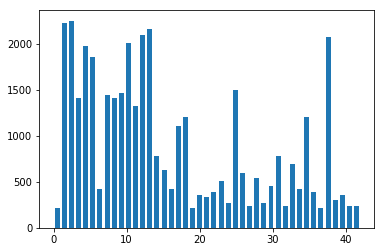

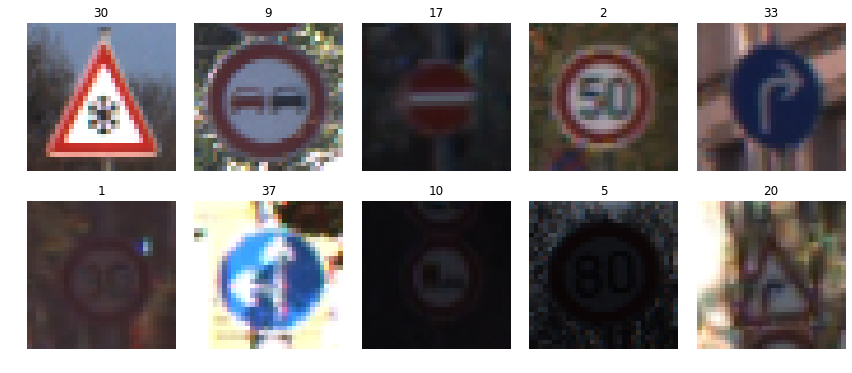

In [2]:
########### Load pickled data ############################
import pickle
training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
#'features' (num examples, width, height, channels).
X_test, y_test = test['features'], test['labels']
#'labels' 2D array containing the label/class id of the traffic sign

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

########### Load Dataset complete ######################

n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print()
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print()
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()


import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

## Step 2 Preprocessing

In [3]:
## 1. Convert to grayscale
X_train_rgb = X_train
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_gry.shape)

X_train = X_train_gry
X_test = X_test_gry

print('done')

RGB shape: (39209, 32, 32, 3)
Grayscale shape: (39209, 32, 32, 1)
done


In [4]:
## 2. Normalize the train and test datasets to (-1,1)
print(np.mean(X_train))
print(np.mean(X_test))

X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128

print(np.mean(X_train_normalized))
print(np.mean(X_test_normalized))

82.66505234601497
82.14846036120173
-0.3541792785467594
-0.3582151534281105


In [5]:
## 3. Generate data additional data

import cv2

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst


def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_warp(img):
    
    rows,cols,_ = img.shape
    
    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

In [6]:
print(np.bincount(y_train))
print("minimum samples for any label:", min(np.bincount(y_train)))

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160
  780  630  420 1110 1200  210  360  330  390  510  270 1500  600  240
  540  270  450  780  240  689  420 1200  390  210 2070  300  360  240
  240]
minimum samples for any label: 210


In [7]:
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

X, y shapes: (39209, 32, 32, 1) (39209,)
0 : |----|----|----|----|----|----|----|----|----|----|----|---
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|--
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |-
15 : |----|----|----|-
16 : |----|----|----|----|----|----|----|--
17 : 
18 : 
19 : |----|----|----|----|----|----|----|----|----|----|----|---
20 : |----|----|----|----|----|----|----|----|---
21 : |----|----|----|----|----|----|----|----|----|-
22 : |----|----|----|----|----|----|----|----|
23 : |----|----|----|----|----|---
24 : |----|----|----|----|----|----|----|----|----|----|--
25 : 
26 : |----|----|----|----
27 : |----|----|----|----|----|----|----|----|----|----|----|
28 : |----|----|----|----|----|
29 : |----|----|----|----|----|----|----|----|----|----|--
30 : |----|----|----|----|----|----|----
31 : |-
32 : |----|----|----|----|----|----|----|----|----|----|----|
33 : |----|----|-
34 : |----|----|----|----|----|----|----|--
35 : 
36 : |----|----|----|----|--

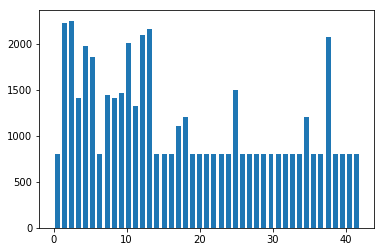

In [8]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## Step 3. Shuflling and Split Validation Set

In [9]:
## Shuffle the training dataset

from sklearn.utils import shuffle

X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

print('done')

done


In [10]:
## Split validation dataset off from training dataset

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)

print("Old X_train size:",len(X_train_normalized))
print("New X_train size:",len(X_train))
print("X_validation size:",len(X_validation))

Old X_train size: 49510
New X_train size: 39608
X_validation size: 9902


## Step 4. Tensorflow Setup part A Tensorflow Graph  

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

### A.1 Placeholder

In [11]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)

print('done')

done


### A.2 Model

Basics
1. op = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME')

In [12]:
from tensorflow.contrib.layers import flatten
#adapted from Sermanet/LeCunn traffic sign classification journal article

def CNN_Model(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())
    #Activation
    x = tf.nn.relu(x)
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    #Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)                
    #Activation.
    x = tf.nn.relu(x)
    #Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    #Layer 3(A): Convolutional. Input = 5x5x16. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)                
    #Activation.
    x = tf.nn.relu(x)
    layer3 = x
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    print("xflat shape:",xflat.get_shape())
    
    #Layer 3(B): Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    print("layer2flat shape:",layer2flat.get_shape())

    #Layer 3(A+B): Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    print("x shape:",x.get_shape())
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    #Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    print("logits shape:",logits.get_shape())
    
    return logits

print('done')

done


### A.3 Cost-function to be optimized

In [14]:
logits = CNN_Model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits, one_hot_y)
#Note: tf.nn.softmax_cross_entropy_with_logits,THIS FUNCTION IS DEPRECATED. 
#It will be removed in a future version.
loss_operation = tf.reduce_mean(cross_entropy)

layer 1 shape: (?, 28, 28, 6)
xflat shape: (?, 400)
layer2flat shape: (?, 400)
x shape: (?, 800)
logits shape: (?, 43)


### A.4 Optimization method and Performance measures

In [16]:
rate = 0.0009
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

## Step 4 Tensorflow Run Part B TensorFlow Session

In [17]:
EPOCHS = 60
BATCH_SIZE = 100

## Evaluate function for validation set
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

done


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

In [ ]:
# Now evaluate the accuracy of the model on the test dataset

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))